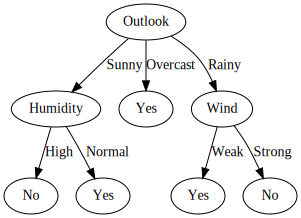

In [13]:
import pandas as pd
import numpy as np
import math
from graphviz import Digraph

def calculate_entropy(data, target_column):
    """Calculates the entropy of a dataset."""
    total_samples = len(data)
    class_counts = data[target_column].value_counts()
    entropy = 0
    for count in class_counts:
        probability = count / total_samples
        entropy -= probability * math.log2(probability)
    return entropy

def calculate_information_gain(data, feature, target_column):
    """Calculates the information gain of a feature."""
    total_samples = len(data)
    weighted_entropy = 0
    for value in data[feature].unique():
        subset = data[data[feature] == value]
        subset_entropy = calculate_entropy(subset, target_column)
        weighted_entropy += (len(subset) / total_samples) * subset_entropy
    return calculate_entropy(data, target_column) - weighted_entropy


def build_tree(data, target_column, features, parent_node_class=None):
    if len(data[target_column].unique()) <= 1:
        return data[target_column].unique()[0]
    if len(features) == 0:
        return parent_node_class

    parent_node_class = data[target_column].mode()[0]

    best_feature = max(features, key=lambda feature: calculate_information_gain(data, feature, target_column))
    tree = {best_feature: {}}
    features.remove(best_feature)

    for value in data[best_feature].unique():
        subset = data[data[best_feature] == value]
        subtree = build_tree(subset, target_column, features.copy(), parent_node_class)
        tree[best_feature][value] = subtree

    return tree


def visualize_tree(tree, dot=None, node_name='Root'):
    if not dot:
        dot = Digraph(comment='Decision Tree')

    if isinstance(tree, dict):
        feature = list(tree.keys())[0]
        dot.node(node_name, label=feature)

        for value, subtree in tree[feature].items():
            child_node_name = node_name + "_" + str(value)
            dot.edge(node_name, child_node_name, label=str(value))
            visualize_tree(subtree, dot, child_node_name)

    else:
        dot.node(node_name, label=str(tree))

    return dot

data = {'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rainy', 'Rainy', 'Rainy', 'Overcast', 'Sunny', 'Sunny', 'Rainy', 'Sunny', 'Overcast', 'Overcast', 'Rainy'],
        'Temperature': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
        'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
        'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Strong'],
        'PlayTennis': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']}
df = pd.DataFrame(data)

target_column = 'PlayTennis'
features = list(df.columns)
features.remove(target_column)
tree = build_tree(df, target_column, features)
dot = visualize_tree(tree)
dot.render('decision_tree')
dot


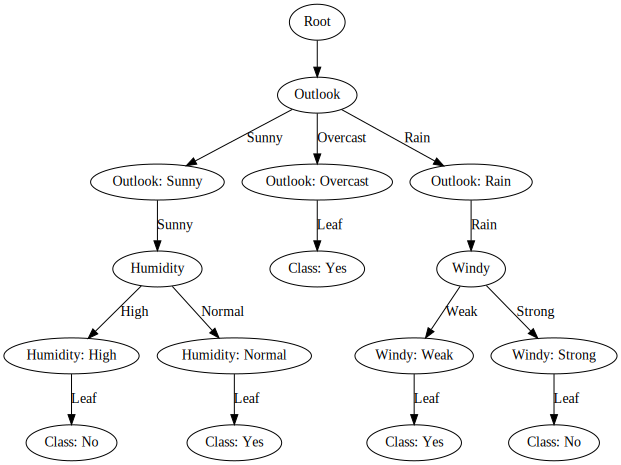

In [12]:


import numpy as np
import pandas as pd
from graphviz import Digraph


def entropy(dataset):
    class_counts = dataset.iloc[:, -1].value_counts()
    prob = class_counts / len(dataset)
    return -np.sum(prob * np.log2(prob))

def information_gain(dataset, feature):
    total_entropy = entropy(dataset)
    feature_values = dataset[feature].value_counts()
    weighted_entropy = 0
    for value, count in feature_values.items():
        subset = dataset[dataset[feature] == value]
        weighted_entropy += (count / len(dataset)) * entropy(subset)
    return total_entropy - weighted_entropy


def best_feature(dataset):
    features = dataset.columns[:-1]
    best_info_gain = -1
    best_feature = None
    for feature in features:
        info_gain = information_gain(dataset, feature)
        if info_gain > best_info_gain:
            best_info_gain = info_gain
            best_feature = feature
    return best_feature


def id3(dataset, max_depth=None, depth=0):
    if len(dataset.iloc[:, -1].unique()) == 1:
        return dataset.iloc[0, -1]
    if len(dataset.columns) == 1:
        return dataset.iloc[:, -1].mode()[0]
    if max_depth is not None and depth >= max_depth:
        return dataset.iloc[:, -1].mode()[0]
    best = best_feature(dataset)
    tree = {best: {}}
    for value in dataset[best].unique():
        subset = dataset[dataset[best] == value]
        tree[best][value] = id3(subset.drop(columns=[best]), max_depth=max_depth, depth=depth+1)
    return tree


def create_tree_diagram(tree, dot=None, parent_name="Root", parent_value=""):
    if dot is None:
        dot = Digraph(format="png", engine="dot")


    if isinstance(tree, dict):
        for feature, branches in tree.items():
            feature_name = f"{parent_name}_{feature}"
            dot.node(feature_name, feature)
            dot.edge(parent_name, feature_name, label=parent_value)

            for value, subtree in branches.items():
                value_name = f"{feature_name}_{value}"
                dot.node(value_name, f"{feature}: {value}")
                dot.edge(feature_name, value_name, label=str(value))


                create_tree_diagram(subtree, dot, value_name, str(value))
    else:
        dot.node(parent_name + "_class", f"Class: {tree}")
        dot.edge(parent_name, parent_name + "_class", label="Leaf")

    return dot

data = pd.read_csv("/content/weather_forecast.csv")
df = pd.DataFrame(data)
tree = id3(df, max_depth=3)
dot = create_tree_diagram(tree)
dot.render("decision_tree", view=True)
dot